# XGBoost Model with Explainer & Outlier Detector
This notebook walks through how to create an XGBoost model trained on the Iris dataset. These are then deployed to Seldon Deploy v1.0 via the API. The workflow for each of the components is as follows:
1. Train algorithm
2. Push trained artefact to Google Storage bucket
3. Create deployment on Seldon Deploy via API


**Predictor**
- Algorithm: XGBoost
- Dataset: Iris (Continuous tabular)

**Explainer**
- Algorithm: AnchorTabular

**Outlier Detector (OD)**
- Algorithm: Mahalanobis Distance Detector

**Drift Detector (DD)**
- Algorithm: Kolmogorov-Smirnov Detector

### Import relevant packages

In [10]:
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi, DriftDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import numpy as np
import pandas as pd

import xgboost as xgb

from alibi.explainers import AnchorTabular

from alibi_detect.od import Mahalanobis
from alibi_detect.cd import KSDrift
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.mapping import ord2ohe
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

import dill
import os

import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [31]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

X = dataset.data
y = dataset.target

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model training

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [34]:
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 3} 

num_round = 20

In [35]:
bst = xgb.train(param, dtrain, num_round)

[18:23:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [36]:
preds = np.asarray([np.argmax(line) for line in bst.predict(dtest)])
print(precision_score(y_test, preds, average="macro"))
print(recall_score(y_test, preds, average="macro"))
print(accuracy_score(y_test, preds))

1.0
1.0
1.0


Perfect, now that our model is nicely overfitted we can save it. 

The XGBoost pre-packaged server expects our model to be called `model.bst` when it is uploaded to our storage bucket.

In [37]:
bst.save_model('model.bst')

Uploading the model to a Google Storage bucket (to run this command you need to have the `gsutil` CLI tool installed). 

The thing to note here is that the pre-packaged XGBoost server expects to look inside of a folder for the `model.bst` artefact. Therefore, we create a `/xgboost` dir to hold our model artefact. 

TODO: Adapt this to AWS so it is more relevant. 

In [9]:
!gsutil cp model.bst gs://tom-seldon-examples/xgboost/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][ 23.5 KiB/ 23.5 KiB]                                                
Operation completed over 1 objects/23.5 KiB.                                     


### Model Deployment

Deploying the model to a Seldon Deploy trial instance using the `seldon-deploy-sdk`. 

First, setting up the configuration and authentication required to access the cluster. 

In [39]:
SD_IP = "159.65.213.233"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"

def auth():
    auth = OIDCAuthenticator(config)
    config.access_token = auth.authenticate("admin@seldon.io", "12341234")
    api_client = ApiClient(config)
    return api_client

In [40]:
DEPLOYMENT_NAME = "xgboost-sample"
NAMESPACE = "dev"
PREPACKAGED_SERVER = "XGBOOST_SERVER"
MODEL_LOCATION = "gs://tom-seldon-examples/xgboost"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [41]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'xgboost-sample',
              'namespace': 'dev',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'xgboost-sample',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
           

### Adding a Model Explainer

Need to define a prediction function which our explainer can make use of. 

In [ ]:
predict_fn = lambda x: bst.predict(xgb.DMatrix(x))

Now, define and fit the AnchorTabular explainer. 

In [ ]:
explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_train, disc_perc=(25, 50, 75))

Predicting the first instance within the test set, and consequently generating an explanation for that prediction.

In [ ]:
idx = 0
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

explanation = explainer.explain(X_test[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Save the explainer. Your explainer must be saved as `explainer.dill` as once again Seldon Deploy will look for this artefact within a top level directory. 

NOTE: Dill is used to serialise the object instead of pickle as it offers a greater flexibilty in the object types which can be serialised. 

In [ ]:
dill.dump(explainer, open( "explainer.dill", "wb"))

Uploading the model to a Google Storage bucket. 

In [ ]:
!gsutil cp explainer.dill gs://tom-seldon-examples/xgboost/explainer.dill

Defining our explainer configuration.

In [ ]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = "gs://tom-seldon-examples/xgboost"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

Inserting our explainer configuration into the original `mldeployment`

In [ ]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

Finally, creating our new deployment with the explainer added. 

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

### Generating an Outlier Detector

In this example we will make use of a Mahalanbois outlier detector. This algorithm calculates an outlier score, which is a measure of distance from the center of the features distribution (Mahalanobis distance). The Mahalanobis distance is focused on the idea of measuring how many standard deviations away our data point is from the mean of the distribution. 

The Mahalanobis outlier detector is an online detector, meaning that it has a running mean and covariance matrix with which it compares the new data points with to classify as outliers or not. It is online in the sense that each new data point contributes to this running mean and covariance matrix. 

The first step is to initialise our outlier detector. There are 4 parameters which will be critical to the performance of our outlier detector: 
* `threshold`: The distance threshold above which our data instance is flagged as an outlier. To begin with we can leave this blank and infer a given threshold later when fitting our detector to the dataset. 
* `n_components`: The number of components to use within the PCA. PCA is used to reduce the number of feature dimensions. This will make it easier to compute the Mahalanbois calculation especially on high feature datasets. 
* `std_clip`: Feature-wise standard deviation used to clip the observations before updating the mean and covariance matrix. 
* `start_clip`: Number of observations before clipping is applied.

If your data has categorical features then these can be specified using the `cat_vars` parameter. 

Firstly, we will set the `n_components` value. The simplest way to set this value is using `n_components == min(n_samples, n_features)` and then scaling down if computational performance slows the computation of outliers.

A more rigourous approach is demonstrated below. This essentially calculates the covariance matrix (how each feature varies with every other feature, and the determines the eigenvalues and eigenvectors of the covariance matrix. 

The eigenvalues capture the variance of each component in the direction of the eigenvector. Therefore, we can use this to understand the contribution of each feature to the overall variance. From here we can make a determination of how many components to include in our PCA, as we now understand the contribution of each of the features. 

In [58]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
cov_mat = np.cov((X_train - mean).T)
cov_mat

array([[ 0.67865476, -0.03956162,  1.24462745,  0.49670868],
       [-0.03956162,  0.20171148, -0.34006162, -0.12484594],
       [ 1.24462745, -0.34006162,  3.07071148,  1.26893557],
       [ 0.49670868, -0.12484594,  1.26893557,  0.56593838]])

In [59]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(f'Eigenvectors \n {eig_vecs}')
print(f'Eigenvectors \n {eig_vals}')

Eigenvectors 
 [[ 0.35922175 -0.66072216 -0.5781132   0.31652976]
 [-0.08867716 -0.72708635  0.60569412 -0.31083185]
 [ 0.85800365  0.16688652  0.08006791 -0.4791323 ]
 [ 0.35626652  0.08331002  0.54084091  0.75738016]]
Eigenvectors 
 [4.15384465 0.25811933 0.08303984 0.02201228]


In [60]:
total = sum(eig_vals)
var_exp = [(i / total)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print("Variance captured by each component:")
print(var_exp)
print(80 * "-")
print("Cumulative variance captured as we travel each component:")
print(cum_var_exp)

Variance captured by each component:
[91.95992565966297, 5.714377120220825, 1.838378258791593, 0.4873189613245974]
--------------------------------------------------------------------------------
Cumulative variance captured as we travel each component:
[ 91.95992566  97.67430278  99.51268104 100.        ]


From the above we can see that 91.9% of the variance is captured by a single component, therefore we could reasonably set `n_components = 1`. However, we gain an additional 5% points by including a second one, and therefore:

In [61]:
n_components = 2

`std_clip` is used to ensure that outliers do not impact the typical operation of the detector. If many, many outliers (e.g. in a DDoS attack, or multiple broken parts in a assembly line) were sent to the detector then the weights (covariance matrix) would shift to include these outliers, therefore we set a `std_clip` whereby any data points above this clip level will have their `stdev` clipped to this maximal value. 

Setting the `std_clip` is case by case dependent, but we will use the following heuristic to set it. We will look at the `stdev` across the features, selecting the one which is the most widely distributed (the highest value). We will then set the `std_clip` to be 2 stdevs away from this maximal value. 

The code snippet below illustrates this.

In [62]:
std_clip = (2 * stdev.max(axis=0)).round(decimals=2)
std_clip

3.49

Finally, the `start_clip` value is used to "warm up" the outlier detector. When the detector is first initialised it can be sensitive to new observations- which lead to large changes in the online mean and covariance matrix. During this period of time we do not want to show the outlier detector any outliers as it can greatly skew the accuracy of the running mean and covariance matrix.

Thus during this "warm up" period we only show the outlier detector examples of normal data, and do not perform any clipping. The `start_clip` value determines after which point we should begin clipping data points and introducing outliers into the mix. 

Therefore `start_clip` in this case will be equal to the length of `X_train`, as we know that there are no outlying data points within the original Iris dataset. 

In [63]:
start_clip = len(X_train)
start_clip

120

In [64]:
threshold = None

od = Mahalanobis(threshold,
                 n_components=n_components,
                 std_clip=std_clip,
                 start_clip=start_clip)

No threshold level set. Need to infer threshold using `infer_threshold`.


If we were dealing with categorical variables we would now run `od.fit(...)` however because the Iris dataset is solely continuous variables we do not need to perform this step. 

We do however now need to set the threshold of Mahalanobis distance above which we consider a data instance an outlier. This can be done using the convenient `infer_threshold()` method. 

We first create a synthetic outlier batch using our training data and labels, with a certain percentage of the batch as outliers. Based upon this percentage of outliers we shall update the threshold value.

In [72]:
np.random.seed(0)
perc_outlier = 5

threshold_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


Once we have created the synthetic data we can determine the threshold using `infer_threshold`:

In [67]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))
threshold = od.threshold

New threshold: 8.10689543287148


We can now test our threshold by generating a second batch of outlying data, this time with a higher proportion of outliers: 

In [80]:
np.random.seed(1)
outlier_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 4) (1000,)
10.0% outliers


Generating outlier predictions from our new detector using the freshly created outlier batch:

In [81]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score: 0.9743589743589743


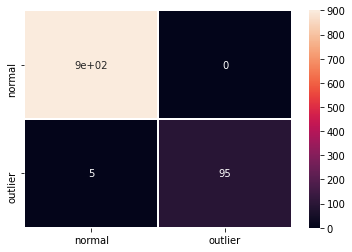

In [82]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

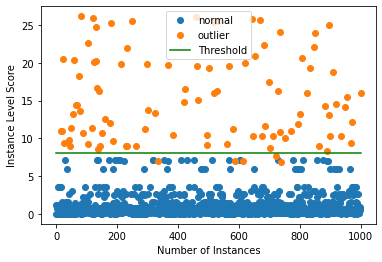

In [83]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

In [ ]:
save_detector(od, "outlier_detector")

In [ ]:
# Recursive copy this time as the OD is saved as a directory containing all the relevant binaries and parameters. 
!gsutil cp -r outlier_detector gs://tom-seldon-examples/xgboost

In [ ]:
OD_URI = 'gs://tom-seldon-examples/xgboost/outlier_detector/'
OD_NAME = 'mahalobanis-od'

od_config = {'deployment': DEPLOYMENT_NAME,
             'deployment_namespace': None,
             'namespace': 'seldon-logs',
             'params': {'drift_batch_size': None,
                        'env_secret_ref': None,
                        'event_source': f'io.seldon.serving.dev-seldondeployment-{DEPLOYMENT_NAME}-outlier',
                        'event_type': 'io.seldon.serving.inference.outlier',
                        'http_port': '8080',
                        'model_name': OD_NAME,
                        'protocol': 'seldon.http',
                        'reply_url': 'http://seldon-request-logger.seldon-logs',
                        'storage_uri': OD_URI,
                        'user_permission': None},
             'prom_scraping': None,
             'url': None}

In [ ]:
od_api = OutlierDetectorApi(auth())
od_api.create_outlier_detector_seldon_deployment(name=DEPLOYMENT_NAME,
                                                 namespace=NAMESPACE,
                                                 outlier_detector=od_config)

### Drift Detection
Next, we will train and deploy a drift detector to the cluster.

In [ ]:
from alibi_detect.cd import KSDrift

dd = KSDrift(
    p_val=0.05,
    X_ref=X_train,
    preprocess_X_ref=False,
    preprocess_kwargs=None,
    alternative='two-sided',
    correction='bonferroni'
)

In [ ]:
preds_drift = dd.predict(X_test, return_p_val=True, return_distance=True)
preds_drift

In [ ]:
## TODO: Add code to perturb examples so that drift is detected.

In [ ]:
save_detector(dd, "drift_detector")

In [ ]:
# Recursive copy this time as the OD is saved as a directory containing all the relevant binaries and parameters. 
!gsutil cp -r drift_detector gs://tom-seldon-examples/xgboost

In [ ]:
DD_URI = 'gs://tom-seldon-examples/xgboost/drift_detector/'
DD_NAME = 'KSDrift-Detector'

dd_config = {'deployment': DEPLOYMENT_NAME,
             'deployment_namespace': None,
             'namespace': 'seldon-logs',
             'params': {'drift_batch_size': '10',
                        'env_secret_ref': None,
                        'event_source': f'io.seldon.serving.dev-seldondeployment-{DEPLOYMENT_NAME}-drift',
                        'event_type': 'io.seldon.serving.inference.drift',
                        'http_port': '8080',
                        'model_name': DD_NAME,
                        'protocol': 'seldon.http',
                        'reply_url': 'http://seldon-request-logger.seldon-logs',
                        'storage_uri': DD_URI,
                        'user_permission': None},
             'prom_scraping': None,
             'url': None}

In [ ]:
dd_api = DriftDetectorApi(auth())
dd_api.create_drift_detector_seldon_deployment(name=DEPLOYMENT_NAME,
                                               namespace=NAMESPACE,
                                               drift_detector=dd_config)